## Classification - II

The learning objectives are to
- Get familiar with more classifiers;
- Learn the use of performance metrics and the ROC curve. 

### Decision Tree

As usual we import the MLJ package and load in the Iris dataset: 

In [28]:
using MLJ

In [29]:
X, y = @load_iris; # loads the iris dataset from MLJBase

To carry on with the same setting as in our previous lab, let's extract the two attributes "sepal_length" and "petal_width" in to X1:   

In [30]:
X1 = selectcols(X, [1,4]) 

(sepal_length = [5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9  …  6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
 petal_width = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1  …  2.4, 2.3, 1.9, 2.3, 2.5, 2.3, 1.9, 2.0, 2.3, 1.8],)

... and get the same training/testing split: 

In [31]:
using Random
Random.seed!(1)
tr_inds, te_inds = partition(1:nrows(X1), 0.7, shuffle=true)

([40, 16, 22, 112, 134, 106, 90, 51, 149, 67  …  48, 87, 63, 118, 12, 50, 132, 82, 34, 5], [78, 70, 129, 127, 4, 96, 143, 76, 94, 123  …  11, 138, 27, 29, 101, 93, 83, 54, 104, 131])

Time for us to load in DecisionTree and create a model. 

In [32]:
# import Pkg; Pkg.add("DecisionTree")
# import Pkg; Pkg.add("MLJDecisionTreeInterface")

In [33]:
Tree = @load DecisionTreeClassifier pkg=DecisionTree

import MLJDecisionTreeInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


MLJDecisionTreeInterface.DecisionTreeClassifier

In [34]:
tree = Tree()

DecisionTreeClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  display_depth = 5, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

Now create the machine using the model and data, and fit!() it:

In [35]:
mach = machine(tree, X1, y)
fit!(mach, rows=tr_inds)

[ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).


trained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = -1, …)
  args: 
    1:	Source @549 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @572 ⏎ AbstractVector{Multiclass{3}}


Now we check out the training performance:

In [36]:
ypred = predict_mode(mach, rows=tr_inds)
accuracy(ypred, y[tr_inds])

0.9809523809523809

... and the testing performance: 

In [37]:
ypred = predict_mode(mach, rows=te_inds)
accuracy(ypred, y[te_inds])

0.9333333333333333

There seems a mismatch between the two. Are we overfitting? Let's try a tree with limited depth:

In [38]:
tree = Tree(max_depth=3)
mach = machine(tree, X1, y)
fit!(mach, rows=tr_inds)
println("Tr. accu.=", accuracy(predict_mode(mach, rows=tr_inds), y[tr_inds]))
println("Te. accu.=", accuracy(predict_mode(mach, rows=te_inds), y[te_inds]))

Tr. accu.=0.9809523809523809
Te. accu.=0.9333333333333333


[ Info: Training machine(DecisionTreeClassifier(max_depth = 3, …), …).


**Task 1.** Using the same training and testing split, experiment with max_depth ranged from 1 to 10. Plot out a run-chart for both training and testing accuracies.  

In [39]:
using Plots

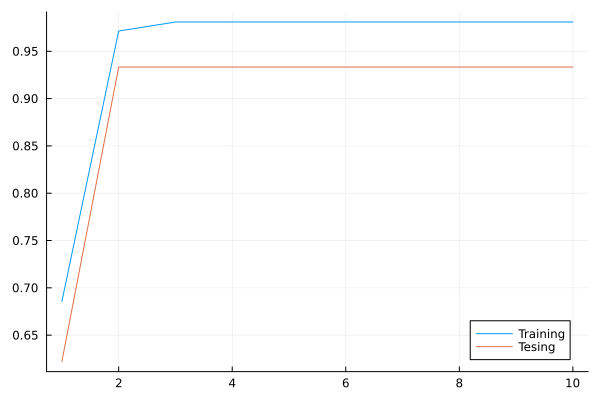

In [40]:
accu_tr = []
accu_te = []
ds = 1:10
for depth in ds
    tree = Tree(max_depth=depth)
    mach = machine(tree, X1, y)
    fit!(mach, rows=tr_inds, verbosity=0)
    push!(accu_tr, accuracy(predict_mode(mach, rows=tr_inds), y[tr_inds]))
    push!(accu_te, accuracy(predict_mode(mach, rows=te_inds), y[te_inds]))
end

plot(ds, accu_tr, label="Training")
plot!(ds, accu_te, label="Tesing")

#### Decision boundary

**Task 2:** Following the examples we experimented in notebook 5, generate the decision boundaries of a decision tree (with max_depth=5) and comment on how it differs from that of the kNN. 

[ Info: Training machine(DecisionTreeClassifier(max_depth = 5, …), …).


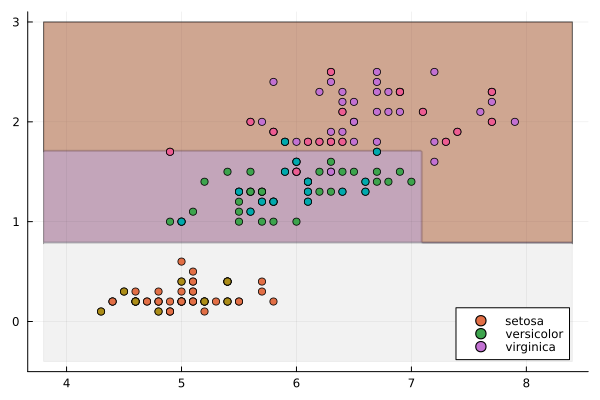

In [41]:
using DataFrames

X1 = DataFrame(X1)

tree = Tree(max_depth=5)
mach = machine(tree, X1, y)
fit!(mach, rows=tr_inds)

dim1_min = minimum(X1[!, 1])
dim1_max = maximum(X1[!, 1])
xx = dim1_min-0.5:0.02:dim1_max+0.5
dim2_min = minimum(X1[!, 2])
dim2_max = maximum(X1[!, 2])
yy = dim2_min-0.5:0.02:dim2_max+0.5
z = []
for d1 in xx
    for d2 in yy
        # Create a DataFrame for prediction
        X_pred = DataFrame(column1=[d1], column2=[d2]) # Adjust the column names as needed
        pred = predict_mode(mach, X_pred)
        push!(z, string(pred))
    end
end


zz = reshape(z, (length(yy), length(xx)))
        
zz = coerce(zz, OrderedFactor)
contourf(xx, yy, zz, bar=false, alpha=0.051, legend=nothing)
scatter!(X1[!, 1], X1[!, 2], group=y, legend=:bottomright)
scatter!(X1[!, 1][te_inds], X1[!, 2][te_inds], group=y[te_inds], label=nothing)


##### Comments 
The decision boundary of knn tends to 'wrap' around data points, whereas decision tree always makes straight cuts on one feature at a time.

#### Confusion matrix

So the classification of testing cases is not perfect. We may wonder where the classification errors occur. MLJ provides the ConfusionMatrix utility for this purpose: 

In [42]:
ypred = predict_mode(mach, rows=te_inds)
ConfusionMatrix()(ypred, y[te_inds])

┌ Warning: The classes are un-ordered,
│ using order: ["setosa", "versicolor", "virginica"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\kapil\.julia\packages\MLJBase\ByFwA\src\measures\confusion_matrix.jl:122


           ┌────────────────────────────────┐
           │          Ground Truth          │
┌──────────┼──────────┬──────────┬──────────┤
│Predicted │  setosa  │versicol… │virginica │
├──────────┼──────────┼──────────┼──────────┤
│  setosa  │    11    │    0     │    0     │
├──────────┼──────────┼──────────┼──────────┤
│versicol… │    0     │    16    │    2     │
├──────────┼──────────┼──────────┼──────────┤
│virginica │    0     │    1     │    15    │
└──────────┴──────────┴──────────┴──────────┘


**Task 3.** According to the confusion matrix, between which classes lies the confusion? \
Report the error cases and relate your findings to the boundary plot you generated in Task 2. 

**Answer**

- 1 versicolor was classified as virginica, and 2 virginica were classified as versicolor. Setosa was perfectly classified.
- This makes sense when we look at the plotted data distribution based on the chosen two features: setosa was well separated from the rest, virginica and versicolor have overlap. 

### SVM for classification

For the second part of the lab, we experiment with the SVM utilities given by MLJ. Uncomment the following cell and run it once to get the packages installed: 

In [43]:
# import Pkg; Pkg.add("MLJLIBSVMInterface")
# import Pkg; Pkg.add("LIBSVM")

What follows is the normal workflow: load in packages, create model, create machine, and fit!...

In [44]:
SVC = @load SVC pkg=LIBSVM

import MLJLIBSVMInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


MLJLIBSVMInterface.SVC

With SVC, we get to specify the kernel type and its degree (and possible other parameters). We have seen an example kernel using polynomial of degree 2 in our lectures. Let's try a polynomial of degree 3:

In [45]:
@load SVC pkg=LIBSVM; 
using LIBSVM

svc_model = SVC(kernel=LIBSVM.Kernel.Polynomial, degree=Int32(3));

import MLJLIBSVMInterface ✔


[ Info: For silent loading, specify `verbosity=0`. 


In [46]:
cy = categorical(y)
svc_mach = machine(svc_model, X1, cy)

untrained Machine; caches model-specific representations of data
  model: SVC(kernel = Polynomial, …)
  args: 
    1:	Source @965 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @231 ⏎ AbstractVector{Multiclass{3}}


In [47]:
fit!(svc_mach) #, rows=tr_inds, verbosity=0)

[ Info: Training machine(SVC(kernel = Polynomial, …), …).


trained Machine; caches model-specific representations of data
  model: SVC(kernel = Polynomial, …)
  args: 
    1:	Source @965 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @231 ⏎ AbstractVector{Multiclass{3}}


With the SVC implementation, predict() (instead of predict_mode()) is used to give the predicted class labels: 

In [48]:
MLJ.predict(svc_mach, rows=te_inds)

45-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "virginica"
 "versicolor"
 "virginica"
 "virginica"
 "setosa"
 "versicolor"
 "virginica"
 "versicolor"
 "versicolor"
 "virginica"
 "virginica"
 "setosa"
 "versicolor"
 ⋮
 "versicolor"
 "versicolor"
 "setosa"
 "virginica"
 "setosa"
 "setosa"
 "virginica"
 "versicolor"
 "versicolor"
 "versicolor"
 "virginica"
 "virginica"

And we can get the training and testing accuracies: 

In [49]:
println("Tr. accu.=", accuracy(MLJ.predict(svc_mach, rows=tr_inds), y[tr_inds]))
println("Te. accu.=", accuracy(MLJ.predict(svc_mach, rows=te_inds), y[te_inds]))

Tr. accu.=0.9714285714285714
Te. accu.=0.9111111111111111


**Task 4.** Experiment with polynomial kernels with the degree varying from 1 to 10, and generate a run chart (accuracy vs. degree).

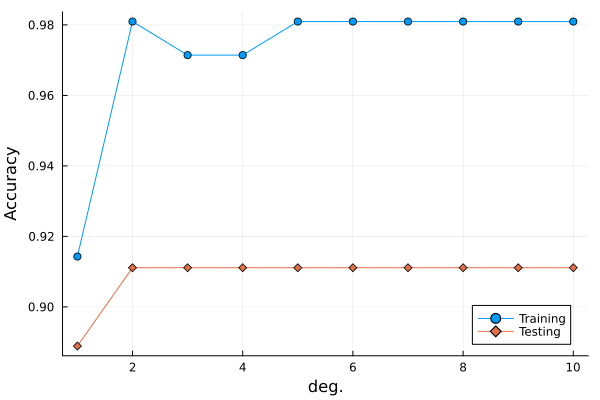

In [50]:
# Task 4 solution
accu_tr = []
accu_te = []

ds = 1:10
for deg in ds
    svc = SVC(kernel=LIBSVM.Kernel.Polynomial, degree=Int32(deg));
    svc_mach = machine(svc, X1, y) 
    MLJ.fit!(svc_mach, rows=tr_inds, verbosity=0) # train machine on a subset of the wrapped data `X`
    push!(accu_tr, accuracy(MLJ.predict(svc_mach, rows=tr_inds), y[tr_inds]))    
    push!(accu_te, accuracy(MLJ.predict(svc_mach, rows=te_inds), y[te_inds]))
end
plot(ds, accu_tr, label="Training", marker=:c, xlabel="deg.", ylabel="Accuracy", legend=:bottomright)
plot!(ds, accu_te, label="Testing", marker=:d)

**Task 5.** Similar to Task 2, generate the classification boundary plots for two SVC classifiers using two polynomial degrees 1 and 5 respectively.  

In [51]:
# common code 
dim1_min = minimum(X1[!,1])
dim1_max = maximum(X1[!,1])
xx = dim1_min-0.5:0.02:dim1_max+0.5
dim2_min = minimum(X1[!,2])
dim2_max = maximum(X1[!,2])
yy = dim2_min-0.5:0.02:dim2_max+0.5

-0.4:0.02:3.0

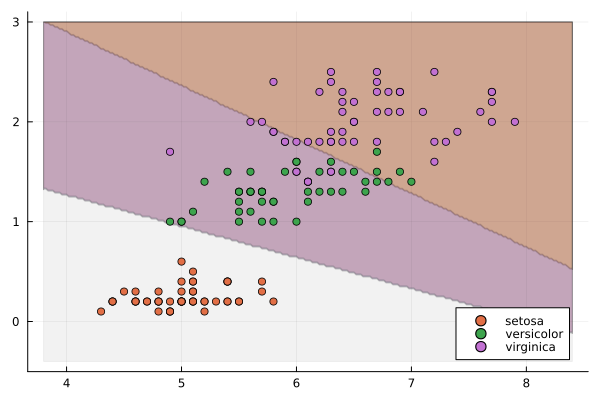

In [52]:
# degree = 1
svc = SVC(kernel=LIBSVM.Kernel.Polynomial, degree=Int32(1));
svc_mach = machine(svc, X1, y) 
fit!(svc_mach, rows=tr_inds, verbosity=0)

z = []
for d1 in xx
    for d2 in yy
        push!(z, string(MLJ.predict(svc_mach, [d1 d2])))
    end
end
zz = reshape(z, (length(yy), length(xx)))
        
zz = coerce(zz, OrderedFactor)
contourf(xx, yy, zz, bar=false, alpha=0.051, legend=nothing)
scatter!(X1[!,1], X1[!,2], group=y, legend=:bottomright)
#scatter!(X1[!,1][tr_inds], X1[!,2][!,tr_inds], group=y[!,tr_inds], label=nothing)

Or, for higher efficiency, we wrap the code into a function and use it for the degree=5 case. 

In [53]:
function mach_boundaries(mach, X)
    dim1_min = minimum(X[!,1])
    dim1_max = maximum(X[!,1])
    xx = dim1_min-0.5:0.02:dim1_max+0.5
    dim2_min = minimum(X[!,2])
    dim2_max = maximum(X[!,2])
    yy = dim2_min-0.5:0.02:dim2_max+0.5
    
    z = []
    for d1 in xx
        for d2 in yy
            push!(z, string(MLJ.predict(svc_mach, [d1 d2])))
        end
    end
    zz = reshape(z, (length(yy), length(xx)))
    zz = coerce(zz, OrderedFactor)
    p = plot()
    contourf!(xx, yy, zz, bar=false, alpha=0.051, legend=nothing)
    scatter!(X1[!,1], X1[!,2], group=y, legend=:bottomright)
    return p
end

mach_boundaries (generic function with 1 method)

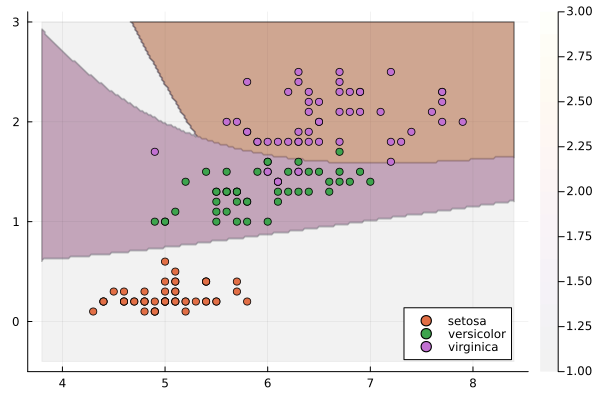

In [54]:
# degree = 5
svc = SVC(kernel=LIBSVM.Kernel.Polynomial, degree=Int32(5));
svc_mach = machine(svc, X1, y) 
fit!(svc_mach, rows=tr_inds, verbosity=0)

mach_boundaries(svc_mach, X1)